<a href="https://colab.research.google.com/github/Ankit777767/ANN_from_scratch-EDA/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN Model for prediction of daily energy consumption

In [4]:
# Import Various libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import seaborn as sns

In [7]:
!unzip /content/AEP_hourly.csv.zip

Archive:  /content/AEP_hourly.csv.zip
  inflating: AEP_hourly.csv          


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# DATA Processing

In [8]:
# Load dataset
df = pd.read_csv('AEP_hourly.csv')

In [9]:
# Extract useful features from the datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['weekday'] = df['Datetime'].dt.weekday
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0) # on weekend it will give 1 value

df.drop(columns=['Datetime'], inplace=True)


In [10]:
# Hour: 0 to 23
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Month: 1 to 12
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [11]:
# EDA-Visualizations
print('DATA PREVIEW')
print(df.head())

DATA PREVIEW
    AEP_MW  hour  day  weekday  month  year  is_weekend  hour_sin  hour_cos  \
0  13478.0     1   31        4     12  2004           0  0.258819  0.965926   
1  12865.0     2   31        4     12  2004           0  0.500000  0.866025   
2  12577.0     3   31        4     12  2004           0  0.707107  0.707107   
3  12517.0     4   31        4     12  2004           0  0.866025  0.500000   
4  12670.0     5   31        4     12  2004           0  0.965926  0.258819   

      month_sin  month_cos  
0 -2.449294e-16        1.0  
1 -2.449294e-16        1.0  
2 -2.449294e-16        1.0  
3 -2.449294e-16        1.0  
4 -2.449294e-16        1.0  


In [12]:
print('Dataset Info')
df.info()

Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   AEP_MW      121273 non-null  float64
 1   hour        121273 non-null  int32  
 2   day         121273 non-null  int32  
 3   weekday     121273 non-null  int32  
 4   month       121273 non-null  int32  
 5   year        121273 non-null  int32  
 6   is_weekend  121273 non-null  int64  
 7   hour_sin    121273 non-null  float64
 8   hour_cos    121273 non-null  float64
 9   month_sin   121273 non-null  float64
 10  month_cos   121273 non-null  float64
dtypes: float64(5), int32(5), int64(1)
memory usage: 7.9 MB


In [13]:
# Check for missing values
print('Missing Values: ')
missing_values = df.isnull().sum()
missing_values

Missing Values: 


,0
AEP_MW,0
hour,0
day,0
weekday,0
month,0
year,0
is_weekend,0
hour_sin,0
hour_cos,0
month_sin,0


<Axes: >

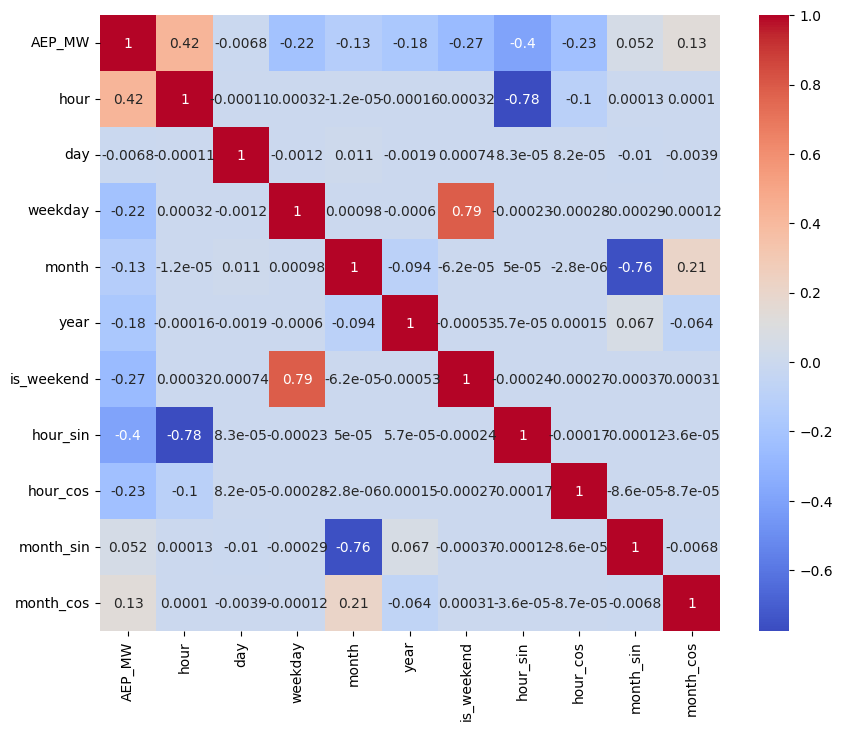

In [18]:
# Correlation Matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [19]:
# From the correlation heatmap, it can be seen that day and year have very low correlation z so these columns may be dropped
df.drop(columns=['day','year'], inplace=True)
# is_weekend and weekday creating redundancy, so one of them can also be dropped
df.drop(columns = ['is_weekend'],inplace =True)

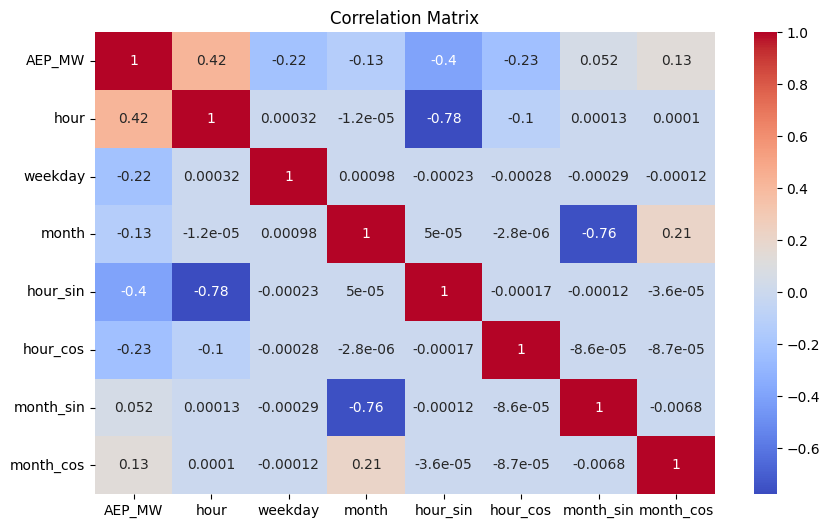

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
  #feature engineering
  df.fillna(df.median(),inplace = True)

In [17]:

# Features and target selection
X = df.drop(columns= ['AEP_MW'])
y = df['AEP_MW']

In [ ]:
df.rename(columns={'AEP_MW': 'EnergyConsumption'}, inplace=True)

In [ ]:
df  # range (-1,1)

,EnergyConsumption,hour,weekday,month,hour_sin,hour_cos,month_sin,month_cos
0,13478.0,1,4,12,0.258819,0.965926,-2.449294e-16,1.000000
1,12865.0,2,4,12,0.500000,0.866025,-2.449294e-16,1.000000
2,12577.0,3,4,12,0.707107,0.707107,-2.449294e-16,1.000000
3,12517.0,4,4,12,0.866025,0.500000,-2.449294e-16,1.000000
4,12670.0,5,4,12,0.965926,0.258819,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...
121268,21089.0,20,0,1,-0.866025,0.500000,5.000000e-01,0.866025
121269,20999.0,21,0,1,-0.707107,0.707107,5.000000e-01,0.866025
121270,20820.0,22,0,1,-0.500000,0.866025,5.000000e-01,0.866025
121271,20415.0,23,0,1,-0.258819,0.965926,5.000000e-01,0.866025


# DATA PRE-PREPARATION FOR TRAINING

In [ ]:
# standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# dataset & dataloaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# ANN Model Definition
class EnergyANN(nn.Module):
    def __init__(self, input_dim):
        super(EnergyANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# Model Initialization
input_dim = X_train.shape[1]
model = EnergyANN(input_dim)


In [ ]:
# LOSS FUNCTION & OPTIMIZER
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the Model
def train_model(model, X_train, y_train, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_model(model, X_train_tensor, y_train_tensor, epochs=100)

Epoch [10/100], Loss: 0.7013
Epoch [20/100], Loss: 0.5902
Epoch [30/100], Loss: 0.5280
Epoch [40/100], Loss: 0.4913
Epoch [50/100], Loss: 0.4674
Epoch [60/100], Loss: 0.4493
Epoch [70/100], Loss: 0.4352
Epoch [80/100], Loss: 0.4243
Epoch [90/100], Loss: 0.4165
Epoch [100/100], Loss: 0.4076


In [ ]:
model.eval()
with torch.no_grad():
  X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), -1)
  test_output = model(X_test_tensor)
  test_mseloss = criterion(test_output, y_test_tensor)
  print(f'Test loss: {test_mseloss.item():.4f}')


Test loss: 0.4651


In [ ]:
# Accuracy Calculation (R-Squared Score)
def r2_score(y_true, y_pred):
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

r2 = r2_score(y_test_tensor, test_output)
print(f'R-Squared Score: {r2.item():.4f}')

R-Squared Score: 0.5261


In [ ]:
# Save Model
torch.save(model.state_dict(), "energy_ann_model.pth")
print("Model saved successfully!")

Model saved successfully!


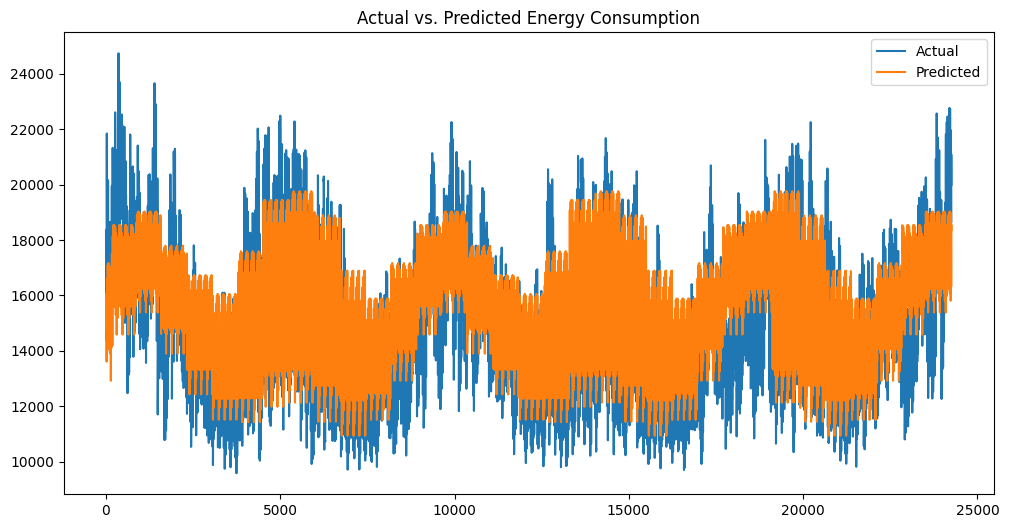

In [ ]:
import matplotlib.pyplot as plt
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())
test_output_actual = scaler.inverse_transform(test_output.numpy())
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual')
plt.plot(test_output_actual, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Energy Consumption')
plt.show()


In [ ]:
# Upload to GitHub
import os
os.system("git init")
os.system("git add .")
os.system("git commit -m 'Initial commit: Added dataset and model script'")
os.system("git branch -M main")
GIT_REPO_URL = "https://github.com/Ankit777767/ANN_from_scratch-EDA"  # Replace with your GitHub repo URL
os.system(f"git remote add origin {GIT_REPO_URL}")
os.system("git push -u origin main")

print("Project successfully uploaded to GitHub!")

Project successfully uploaded to GitHub!
